In [1]:
### Imports 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pysam



In [2]:
### Parameters
sample_assembler = "salad-irg/test-cluster/"
key =  "reads" #cobinning / reads / short_reads / additional_reads_cobinning
checkm_report_path = "../outputs/" + sample_assembler + "/metabat2_bins_" + key + "_alignement/checkm_report.txt"
bin_prefix = "../outputs/" + sample_assembler + "/metabat2_bins_" + key + "_alignement/bins/"
reads_path = "/groups/genscale/nimauric/long_reads/SMRTcell1-M8-fev-sal-irg-1.hifi_reads.fastq" #biocolective_139369_vegan_gut.fastq" #zymoD6331.fastq" #
alignement_path ="../outputs/" + sample_assembler + "/reads_on_contigs.bam"
threshold = 0

In [3]:
### I) Bin => Quality

# Import checkm report
bin_to_quality = pd.read_csv(checkm_report_path, delim_whitespace=True, skiprows=6, 
    names = ["Bin ID", "Marker", "lineage", "genomes", "markers", "sets", "0", "1", "2", "3", "4", "5+", 
             "Completeness", "Contamination", "Strain hetero", "Contigs", "Size", "N50", "N50/Size"])

# Define quality
def GSCS_quality(contamination, completeness, contigs, size) : 
    if ((contamination <=1) and (completeness >=99) and (contigs <=1)) : 
        return "near complete"   
    if ((contamination <=5) and (completeness >=90)) :
        return "high quality"     
    if ((contamination <=10) and (completeness >=50)) :
        return "medium quality"   
    return "low quality"
bin_to_quality["Quality"] = bin_to_quality.apply(lambda x: GSCS_quality(x['Contamination'], x['Completeness'], x['Contigs'], x['Size']), axis=1)

# Translate to a dictionary and keep only relevant information
bin_to_quality = {bin_id: quality for bin_id, quality in zip(bin_to_quality["Bin ID"], bin_to_quality["Quality"])}


/tmp/ipykernel_14537/1460867707.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bin_to_quality = pd.read_csv(checkm_report_path, delim_whitespace=True, skiprows=6,


In [4]:
### II) Contig => Bin
max_bin = str(len(bin_to_quality.keys()))
bin_number = 0
contig_to_bin={}
for bin_name in bin_to_quality.keys() : 
    bin_number +=1
    print("\rprocessing bin " + str(bin_number) + "/" + max_bin + "...", end='', flush=True)
    
    with open(bin_prefix + bin_name + ".fa", "r") as fasta_file :
        for record in SeqIO.parse(fasta_file, "fasta"):
            contig_to_bin[record.name] = bin_name
        



processing bin 291/291...

In [5]:
### III) Alignement => Quality
qualities = ["no alignement", "unbinned", "low quality", "medium quality", "high quality","near complete"]
alignement_to_quality = {}

with pysam.AlignmentFile(alignement_path, "rb") as bam:
    for alignment in bam.fetch() :

        read_name = alignment.query_name
        try : 
            quality = bin_to_quality[contig_to_bin[alignment.reference_name]]
        except KeyError :
            quality = "unbinned"
        start_pos = alignment.reference_start
        end_pos = alignment.reference_end

        if read_name not in alignement_to_quality :
            alignement_to_quality[read_name] = [(start_pos, end_pos, quality)]
        else :
            for pos_range in range(len(alignement_to_quality[read_name])) :
                updated_alignement_list = [],
                alignement = alignement_to_quality[read_name][pos_range]
                alignement_start = alignement[0]
                alignement_end = alignement[1]     

                if qualities.index(quality) <= qualities.index(alignement[2]) : # If of lower quality, trim the new entry
                    # If beggining of current overlap with end of alignement
                    if start_pos >= alignement_start and start_pos < alignement_end :
                        start_pos = alignement_end
                    # If end of current overlap with beggining of alignement
                    if end_pos > alignement_start and end_pos <= alignement_end :
                        end_pos = alignement_start
                else : # trim the existing alignement
                    # If beggining of current overlap with end of comparison
                    if start_pos >= alignement_start and start_pos < alignement_end :
                        alignement_end = start_pos
                    # If end of current overlap with beggining of comparison
                    if end_pos > alignement_start and end_pos <= alignement_end :
                        alignement_start = end_pos
                    if(alignement_start > alignement_end) : 
                        alignement_to_quality[read_name][pos_range] = (alignement_start, alignement_end, alignement[2])   
                    else : 
                        # can't remove from list without breaking the list
                        alignement_to_quality[read_name][pos_range] = (0,0, "no alignement")      
            # If not empty, add the new alignement
            if start_pos > end_pos : 
                alignement_to_quality[read_name].append((start_pos, end_pos, quality))
            

# Remove alignements with quality "no alignements" and empty reads
for read in alignement_to_quality:
    alignement_to_quality[read] = [alignment for alignment in alignement_to_quality[read] if alignment[2] != "no alignement"]

alignement_to_quality = {read : alignement_to_quality[read] for read in alignement_to_quality if alignement_to_quality[read] != []}
alignement_to_quality

[W::hts_idx_load3] The index file is older than the data file: ../outputs/salad-irg/test-cluster//reads_on_contigs.bam.bai


{'m64122_211021_080159/162529551/ccs': [(0, 2184, 'unbinned')],
 'm64122_211021_080159/28773170/ccs': [(0, 2184, 'unbinned')],
 'm64122_211021_080159/140968703/ccs': [(0, 2083, 'unbinned')],
 'm64122_211021_080159/97127219/ccs': [(5, 1881, 'unbinned')],
 'm64122_211021_080159/16255417/ccs': [(5, 2083, 'unbinned')],
 'm64122_211021_080159/28051349/ccs': [(5, 2083, 'unbinned')],
 'm64122_211021_080159/132580098/ccs': [(5, 2083, 'unbinned')],
 'm64122_211021_080159/78186923/ccs': [(12, 2083, 'unbinned')],
 'm64122_211021_080159/177932943/ccs': [(290, 2083, 'unbinned')],
 'm64122_211021_080159/31327682/ccs': [(0, 2991, 'low quality')],
 'm64122_211021_080159/112331361/ccs': [(0, 7850, 'low quality')],
 'm64122_211021_080159/144182110/ccs': [(0, 3046, 'low quality')],
 'm64122_211021_080159/94307802/ccs': [(0, 1305, 'low quality')],
 'm64122_211021_080159/47382538/ccs': [(0, 3752, 'low quality')],
 'm64122_211021_080159/34146043/ccs': [(0, 4050, 'low quality'),
  (4050, 0, 'low quality')],


In [6]:
### IV) get read length and number
reads_length = 0
reads_count = 0
for title, seq, qual in FastqGeneralIterator(reads_path) :
    reads_length += len(seq)
    reads_count += 1
    pass


In [7]:
### V) Visualisation
alignements_length = {"no alignement" : 0, "unbinned" : 0, "low quality" : 0, "medium quality" : 0, "high quality" : 0,"near complete" : 0}
aligned_reads_count = {"no alignement" : 0, "unbinned" : 0, "low quality" : 0, "medium quality" : 0, "high quality" : 0,"near complete" : 0}

for p in alignement_to_quality.values() : 
    best_alignement = 0
    for a in p : 
        alignements_length[a[2]] += a[1] - a[0]
        best_alignement = max(qualities.index(a[2]), best_alignement)

        aligned_reads_count[qualities[best_alignement]] +=1

aligned_reads_count_ratio = {}
alignements_length_ratio = {}
for q in qualities : 
    aligned_reads_count_ratio[q] = aligned_reads_count[q] / reads_count
    alignements_length_ratio[q] = alignements_length[q]/ reads_length 

    print("quality :", q)
    print("aligned reads over total reads count ratio : {:.2f}% ({}/{})".format(aligned_reads_count_ratio[q] * 100,aligned_reads_count[q], reads_count ))
    print("alignement length over total reads length ratio : {:.2f}% ({}/{})".format(alignements_length_ratio[q] * 100, alignements_length[q], reads_length))
    print()

print("in case of multiple alignements per reads, count read only for best quality.")
print("in case of overlapping alignements per reads, count overlap only for best quality.")


quality : no alignement
aligned reads over total reads count ratio : 0.00% (0/2913016)
alignement length over total reads length ratio : 0.00% (0/20251105762)

quality : unbinned
aligned reads over total reads count ratio : 14.69% (427915/2913016)
alignement length over total reads length ratio : 5.06% (1024636621/20251105762)

quality : low quality
aligned reads over total reads count ratio : 39.41% (1148149/2913016)
alignement length over total reads length ratio : 18.70% (3787657170/20251105762)

quality : medium quality
aligned reads over total reads count ratio : 0.00% (0/2913016)
alignement length over total reads length ratio : 0.00% (0/20251105762)

quality : high quality
aligned reads over total reads count ratio : 0.00% (0/2913016)
alignement length over total reads length ratio : 0.00% (0/20251105762)

quality : near complete
aligned reads over total reads count ratio : 0.00% (0/2913016)
alignement length over total reads length ratio : 0.00% (0/20251105762)

in case of mult

,near complete,high quality,medium quality,low quality,unbinned
aligned_reads_count_ratio,0.0,0.0,0.0,0.394144,0.146898
alignement_length_ratio,0.0,0.0,0.0,0.187035,0.050597


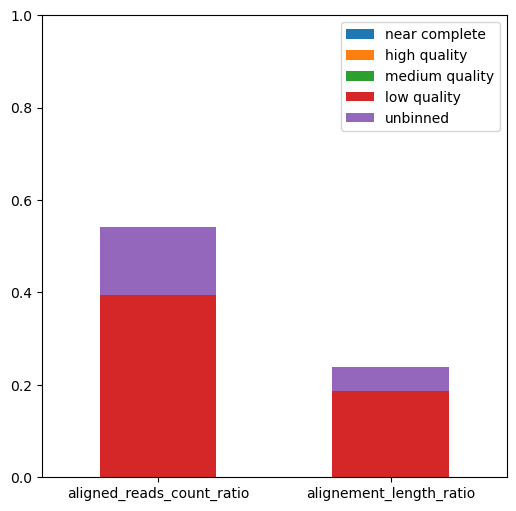

In [8]:

df = pd.concat([pd.DataFrame(aligned_reads_count_ratio, index=["aligned_reads_count_ratio"]), pd.DataFrame(alignements_length_ratio, index=["alignement_length_ratio"]) ])
df  = df.drop("no alignement",axis=1)
df = df[["near complete", "high quality", "medium quality", "low quality", "unbinned"]]
plt.figure(figsize=(6,6))
axes = plt.axes()

df.plot(kind='bar', stacked=True, ax=axes)
axes.set_ylim([0, 1])
plt.xticks(rotation=0, ha='center')

df